In [97]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
from numpy.random import seed
#set_random_seed(1)
seed(1)

In [98]:
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [99]:
df = pd.read_csv("../content/Frequency measurement_8.csv")

In [100]:
df.head()

,Width_cm,Leanth_cm,Thickness_cm,Dielectric_constant,Mode_m,Mode_n,Meas_Freq_MHz
0,0.850,1.290,0.017,2.22,1,0,7740
1,0.790,1.185,0.017,2.22,1,0,8450
2,2.000,2.500,0.079,2.22,1,0,3970
3,1.063,1.183,0.079,10.20,1,0,7730
4,0.910,1.000,0.127,2.33,1,0,4600


In [101]:
df2 = df[['Width_cm','Leanth_cm','Thickness_cm','Dielectric_constant','Mode_m','Mode_n','Meas_Freq_MHz']]
df2.head()

,Width_cm,Leanth_cm,Thickness_cm,Dielectric_constant,Mode_m,Mode_n,Meas_Freq_MHz
0,0.850,1.290,0.017,2.22,1,0,7740
1,0.790,1.185,0.017,2.22,1,0,8450
2,2.000,2.500,0.079,2.22,1,0,3970
3,1.063,1.183,0.079,10.20,1,0,7730
4,0.910,1.000,0.127,2.33,1,0,4600


In [102]:
df3 = df2.fillna(df2.mean())

In [103]:
X = df3.drop('Meas_Freq_MHz', axis = 1)
y = df3['Meas_Freq_MHz']
print('Shape of X = ', X.shape)
print('Shape of y = ', y.shape)

Shape of X =  (68, 6)
Shape of y =  (68,)


In [104]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=51)
print('Shape of X_train = ', X_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of y_test = ', y_test.shape)

Shape of X_train =  (54, 6)
Shape of y_train =  (54,)
Shape of X_test =  (14, 6)
Shape of y_test =  (14,)


In [105]:
sc = StandardScaler()
sc.fit(X_train )

StandardScaler()

In [90]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse
    

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared

In [106]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])

In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

### MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [93]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [108]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 100)               700       
                                                                 
 dense_37 (Dense)            (None, 1)                 101       
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


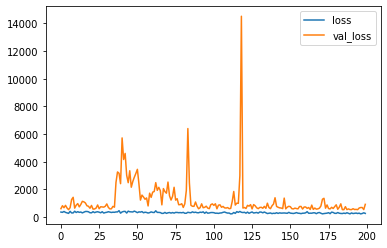

In [109]:
model.compile(
    #optimizer='adam',
    optimizer='sgd',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=200,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

### CNN for RESONANCE FREQUENCY MEASUREMENT

1.   List item
2.   List item



* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [95]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mae', optimizer=adam)
model_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5, 64)             192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 50)                6450      
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 6,693
Trainable params: 6,693
Non-trainable params: 0
___________________________________________________

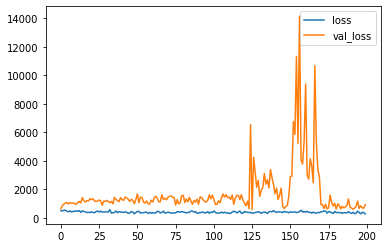

In [96]:
model.compile(
    #optimizer='adam',
    optimizer='sgd',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=200,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

### Comparing models

#### LSTM on train and validation

In [72]:
layers.Dense(16, activation='relu'),
layers.BatchNormalization(),

(<keras.layers.normalization.batch_normalization.BatchNormalization at 0x7fe68eb5d9d0>,)

In [73]:
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),

(<keras.layers.core.activation.Activation at 0x7fe68ebc9a30>,)

In [74]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[6]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

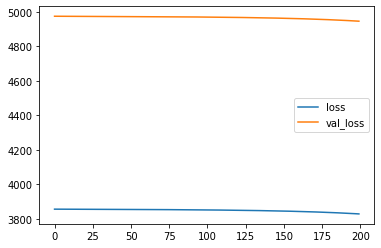

In [75]:
model.compile(
    #optimizer='adam',
    optimizer='sgd',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=200,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

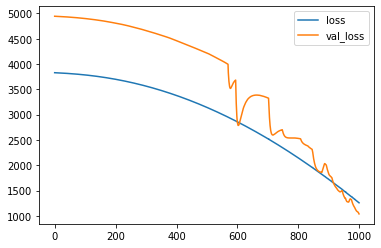

In [76]:
model.compile(
    optimizer='adam',
    #optimizer='sgd',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=1000,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [ ]:
WE CHANGE EPOCH ,LOSS=ADAM,SGD ETC AND CHOOSE DIFFERENT MODELS